In [3]:
# scikit-learn pereptron and adaline implementations
import sklearn
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
# Other imports
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import combinations


In [5]:
### Reading-in
file_path = 'project_adult.csv'
file_path2 = 'project_validation_inputs.csv'

# read_csv calls:
df_adult = pd.read_csv(file_path, header=0, encoding='utf-8')
df_validation = pd.read_csv(file_path2, header=0, encoding='utf-8')

In [6]:
# Preprocess the dataset: handle missing values, encode categorical features, standardize numerical features, 
# and separate features from target.
def preprocess_data(df, target_column='income', fit_scaler=True, return_split=False, test_size=0.2, random_state=42):
    
    global trained_scaler
    
    print(f"Original data shape: {df.shape}")
    print(f"Original data columns: {df.columns.tolist()}")

    # Handle missing values 
    df.replace('?', np.nan, inplace=True)
    df.dropna(inplace=True)
    
    print(f"After handling missing values shape: {df.shape}")

    # Keep track of rows indexes
    df = df.reset_index(drop=True)

    # SEPARATE X AND y ONLY IF target_column IS PROVIDED AND EXISTS
    if target_column is not None and target_column in df.columns:
        y = df[target_column]
        X = df.drop(columns=[target_column])
        print(f"After separation - X shape: {X.shape}, y shape: {y.shape}")
    else:
        X = df.copy()
        y = None
        print(f"No target column specified or found. Using all columns as features. X shape: {X.shape}")
    
    # Encode categorical features (only on X, not y)
    categorical_cols = X.select_dtypes(include=['object']).columns
    print(f"Categorical columns to encode: {categorical_cols.tolist()}")
    
    
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    print(f"After encoding categorical features shape: {X.shape}")

    # Standardize numerical features
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    
    # Only use columns that actually exist in X
    numeric_cols = [col for col in numeric_cols if col in X.columns]
    print(f"Numeric columns to scale: {numeric_cols}")
    
    if numeric_cols:
        if fit_scaler:
            # For training data - fit and transform
            scaler = StandardScaler()
            X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
            # Save the scaler for later use
            trained_scaler = scaler
            print("Fitted new scaler on training data")
        else:
            # For validation data - transform only using pre-fitted scaler
            if trained_scaler is not None:
                X[numeric_cols] = trained_scaler.transform(X[numeric_cols])
                print("Used pre-fitted scaler")
            else:
                print("Warning: No pre-fitted scaler found. Fitting new one...")
                scaler = StandardScaler()
                X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
                trained_scaler = scaler
    else:
        print("Warning: No numeric columns found for scaling")
    
    # Ensure all columns are numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Fill any NaN values
    X = X.fillna(0)
    
    print(f"Final processed features shape: {X.shape}")
    
    if return_split and y is not None:
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"Train/test split - X_train: {X_train.shape}, X_test: {X_test.shape}")
        return X_train, X_test, y_train, y_test
    elif return_split and y is None:
        raise ValueError("Cannot return split when no target column is available")
    else:
        if y is not None:
            return X, y
        else:
            return X  # Return only X if no target column

In [7]:
# Preprocess and split in one step
X_train, X_test, y_train, y_test = preprocess_data(
    df_adult, 
    target_column='income', 
    fit_scaler=True, 
    return_split=True,
    test_size=0.2,
    random_state=42
)

# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Original data shape: (26048, 16)
Original data columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
After handling missing values shape: (24157, 16)
After separation - X shape: (24157, 15), y shape: (24157,)
Categorical columns to encode: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
After encoding categorical features shape: (24157, 97)
Numeric columns to scale: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Fitted new scaler on training data
Final processed features shape: (24157, 97)
Train/test split - X_train: (19325, 97), X_test: (4832, 97)
Scikit-learn Perceptron accuracy: 0.7510
Scikit-learn Adaline (SGDClassifier) accuracy: 0.7510


In [8]:
# Train Perceptron and Adline models (at least AdalineSGD).
# Find the accuracy of your best models from both algorithms
class Perceptron:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.w_ = None
        self.errors_ = []

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)


class AdalineSGD:
    def __init__(self, eta=0.0001, n_iter=50, random_state=1, shuffle=True):
        self.eta = eta  
        self.n_iter = n_iter
        self.random_state = random_state
        self.shuffle = shuffle
        self.w_ = None
        self.cost_ = []

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        self.cost_ = []
        
        # Standardize features if not already done (crucial for Adaline)
        X_std = (X - X.mean(axis=0)) / X.std(axis=0)
        
        for i in range(self.n_iter):
            if self.shuffle:
                indices = np.random.permutation(len(y))
                X_std, y = X_std[indices], y[indices]
            
            total_cost = 0
            for xi, target in zip(X_std, y):
                output = self.net_input(xi)
                error = target - output
                
                # Gradient clipping to prevent explosion
                error = np.clip(error, -10, 10)
                
                # Update weights
                self.w_[1:] += self.eta * xi * error
                self.w_[0] += self.eta * error
                
                total_cost += 0.5 * error**2
            
            avg_cost = total_cost / len(y)
            self.cost_.append(avg_cost)
            
            # Early stopping if cost starts increasing
            if len(self.cost_) > 1 and self.cost_[-1] > self.cost_[-2] * 10:
                print(f"Early stopping at epoch {i+1} due to cost increase")
                break
                
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        # Standardize test data using training statistics
        X_std = (X - X.mean(axis=0)) / X.std(axis=0)
        return np.where(self.net_input(X_std) >= 0.0, 1, -1)


# Convert labels to numeric (-1, 1)
y_train_numeric = y_train.map({'<=50K': -1, '>50K': 1}).values
y_test_numeric = y_test.map({'<=50K': -1, '>50K': 1}).values

# Convert to numpy arrays (ensure they're float for Adaline)
X_train_array = X_train.values.astype(float)
X_test_array = X_test.values.astype(float)

# Train Perceptron
print("Training Perceptron...")
ppn = Perceptron(eta=0.01, n_iter=50, random_state=42)
ppn.fit(X_train_array, y_train_numeric)

# Train AdalineSGD  
print("Training AdalineSGD...")
ada = AdalineSGD(eta=0.0001, n_iter=50, random_state=42, shuffle=True)  # Smaller eta for Adaline
ada.fit(X_train_array, y_train_numeric)

# Make predictions
y_pred_ppn = ppn.predict(X_test_array)
y_pred_ada = ada.predict(X_test_array)

# Calculate accuracies
acc_ppn = np.mean(y_pred_ppn == y_test_numeric)
acc_ada = np.mean(y_pred_ada == y_test_numeric)

print(f"Perceptron accuracy: {acc_ppn:.4f}")
print(f"AdalineSGD accuracy: {acc_ada:.4f}")

Training Perceptron...
Training AdalineSGD...
Perceptron accuracy: 0.7508
AdalineSGD accuracy: 0.7512


/tmp/ipykernel_730/3735841708.py:84: RuntimeWarning: invalid value encountered in divide
  X_std = (X - X.mean(axis=0)) / X.std(axis=0)


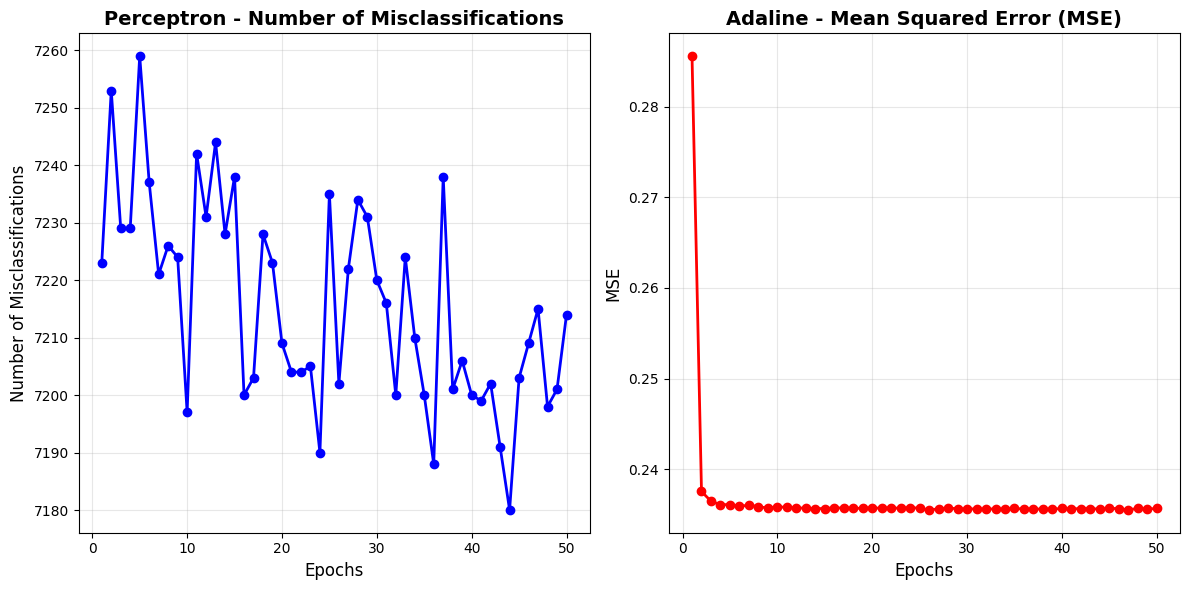

Final Perceptron misclassifications: 7214
Final Adaline MSE: 0.235658
Perceptron converged: No


In [9]:
# Plotting the number of misclassifications (Perceptron) and MSE (Adaline) over epochs
plt.figure(figsize=(12, 6))

# Perceptron misclassifications
plt.subplot(1, 2, 1)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o', color='blue', linewidth=2)
plt.title('Perceptron - Number of Misclassifications', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Number of Misclassifications', fontsize=12)
plt.grid(True, alpha=0.3)

# Adaline MSE
plt.subplot(1, 2, 2)
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o', color='red', linewidth=2)
plt.title('Adaline - Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final values
print(f"Final Perceptron misclassifications: {ppn.errors_[-1]}")
print(f"Final Adaline MSE: {ada.cost_[-1]:.6f}")
print(f"Perceptron converged: {'Yes' if ppn.errors_[-1] == 0 else 'No'}")

In [10]:
# Use best performing models to predict outputs for project_validation_inputs.
# Preprocess the validation data for prediction
X_validation = preprocess_data(
    df_validation, 
    target_column=None,
    fit_scaler=False,
    return_split=False
)

# Fix feature alignment
expected_features = sk_ppn.feature_names_in_
missing_features = set(expected_features) - set(X_validation.columns)

for feature in missing_features:
    X_validation[feature] = 0

X_validation = X_validation[expected_features]

# Make predictions
perceptron_predictions = sk_ppn.predict(X_validation)
adaline_predictions = sk_ada.predict(X_validation)

# Create results with original data for context
results_df = df_validation.copy().reset_index(drop=True)
results_df['Perceptron_Prediction'] = perceptron_predictions
results_df['Adaline_Prediction'] = adaline_predictions
results_df['Models_Agree'] = results_df['Perceptron_Prediction'] == results_df['Adaline_Prediction']

Original data shape: (6513, 15)
Original data columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
After handling missing values shape: (6005, 15)
No target column specified or found. Using all columns as features. X shape: (6005, 15)
Categorical columns to encode: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
After encoding categorical features shape: (6005, 95)
Numeric columns to scale: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Used pre-fitted scaler
Final processed features shape: (6005, 95)


In [11]:
# Display detailed prediction results
# Find the accuracy on the validation data using your best models for both.
print("PREDICTION RESULTS FOR VALIDATION DATA")
print("=" * 60)
print(f"Total predictions made: {len(results_df):,}")
print(f"Models agree on: {results_df['Models_Agree'].sum():,} samples")
print(f"Models disagree on: {len(results_df) - results_df['Models_Agree'].sum():,} samples")

print("\n" + "=" * 40)
print("PREDICTION DISTRIBUTION")
print("=" * 40)
print("PERCEPTRON MODEL:")
print(results_df['Perceptron_Prediction'].value_counts())
print(f"Ratio: {(results_df['Perceptron_Prediction'] == '>50K').mean():.3f}")

print("\nADALINE MODEL:")
print(results_df['Adaline_Prediction'].value_counts())
print(f"Ratio: {(results_df['Adaline_Prediction'] == '>50K').mean():.3f}")

print("\n" + "=" * 40)
print("DETAILED SAMPLE PREDICTIONS")
print("=" * 40)
print("First 20 predictions with context:")
sample_cols = ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 
               'Perceptron_Prediction', 'Adaline_Prediction', 'Models_Agree']
print(results_df[sample_cols].head(20).to_string(index=False))

print("\n" + "=" * 40)
print("CASES WHERE MODELS DISAGREE")
print("=" * 40)
disagreements = results_df[~results_df['Models_Agree']]
if not disagreements.empty:
    print(f"Models disagree on {len(disagreements)} cases:")
    print(disagreements[sample_cols].to_string(index=False))
else:
    print("Perfect agreement between models!")

print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (Based on Test Data)")
print("=" * 40)
print("Note: Validation accuracy cannot be calculated without true labels")
print(f"Perceptron Test Accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")
print(f"Adaline Test Accuracy:    {accuracy_score(y_test, sk_y_pred_ada):.4f}")

# Show training data distribution for comparison
print(f"\nTraining data distribution:")
print(f"<=50K: {14518} samples ({(14518/(14518+4807)):.1%})")
print(f">50K:  {4807} samples ({(4807/(14518+4807)):.1%})")


PREDICTION RESULTS FOR VALIDATION DATA
Total predictions made: 6,005
Models agree on: 6,004 samples
Models disagree on: 1 samples

PREDICTION DISTRIBUTION
PERCEPTRON MODEL:
Perceptron_Prediction
<=50K    6003
>50K        2
Name: count, dtype: int64
Ratio: 0.000

ADALINE MODEL:
Adaline_Prediction
<=50K    6004
>50K        1
Name: count, dtype: int64
Ratio: 0.000

DETAILED SAMPLE PREDICTIONS
First 20 predictions with context:
 age        workclass    education        occupation  hours-per-week Perceptron_Prediction Adaline_Prediction  Models_Agree
  27          Private Some-college      Adm-clerical              38                 <=50K              <=50K          True
  45        State-gov      HS-grad   Exec-managerial              40                 <=50K              <=50K          True
  29          Private    Bachelors   Exec-managerial              55                 <=50K              <=50K          True
  30          Private    Bachelors Machine-op-inspct              40        

In [12]:
# Quick check: Look at the 1-2 people predicted as >50K
high_income_predictions = results_df[
    (results_df['Perceptron_Prediction'] == '>50K') | 
    (results_df['Adaline_Prediction'] == '>50K')
]

print("Individuals predicted as >50K:")
print(high_income_predictions[['age', 'education', 'occupation', 'capital-gain', 
                              'hours-per-week', 'Perceptron_Prediction', 'Adaline_Prediction']].to_string(index=False))

Individuals predicted as >50K:
 age   education     occupation  capital-gain  hours-per-week Perceptron_Prediction Adaline_Prediction
  47 Prof-school Prof-specialty             0              60                  >50K              <=50K
  31     Masters Prof-specialty         14084              50                  >50K               >50K


In [13]:
# Export the predictions 
perceptron_predictions = pd.DataFrame(perceptron_predictions)
adaline_predictions = pd.DataFrame(adaline_predictions)

perceptron_predictions.to_csv('Group_22_Perceptron_PredictedOutputs.csv', index=False)
adaline_predictions.to_csv('Group_22_Adaline_PredictedOutputs.csv', index=False)

# Question 3
### Implement Logistic Regression and SVM using scikit-learn

#### Logistic Regression

In [14]:
# X_train, X_test, y_train, y_test already defined 

# Initialize model
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=500)
model.fit(X_train, y_train.values.ravel())

# Predict on the test data
y_pred_lr = model.predict(X_test)

/home/brynn/Repos/ML/pyml-book2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

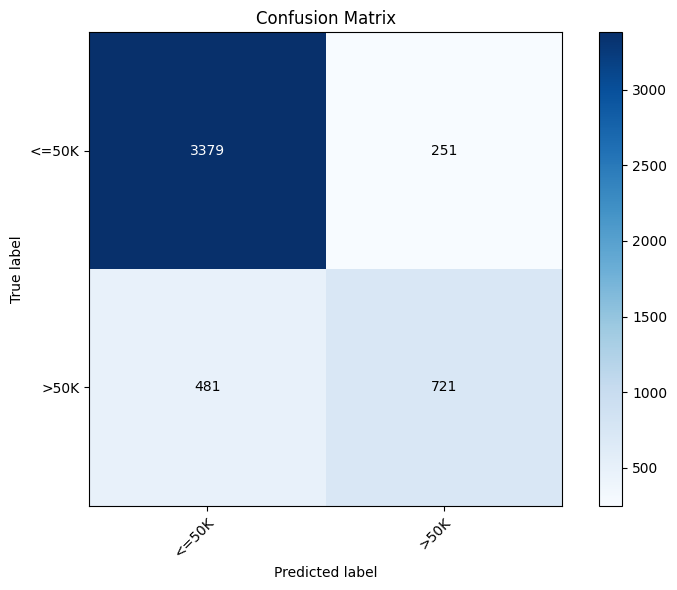


Accuracy: 0.8485099337748344


In [16]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, y_test)

# Print accuracy 
print(f"\nAccuracy: {accuracy_score(y_test,y_pred_lr)}")

In [17]:
# Use GridSearchCV to find the best hyperparameters
param_grid = {
    # Question 4f: Vary the C values of the scikit-learn LogisticRegression
    'C':  [0.01, 1.0, 100.0]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=200),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/brynn/Repos/ML/pyml-book2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/brynn/Repos/ML/pyml-book2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modul

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 1.0, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1.0}
Best cross-validation accuracy: 0.8445

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8466

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      3630
        >50K       0.75      0.58      0.65      1202

    accuracy                           0.85      4832
   macro avg       0.81      0.76      0.78      4832
weighted avg       0.84      0.85      0.84      4832


Confusion Matrix:
[[3394  236]
 [ 505  697]]


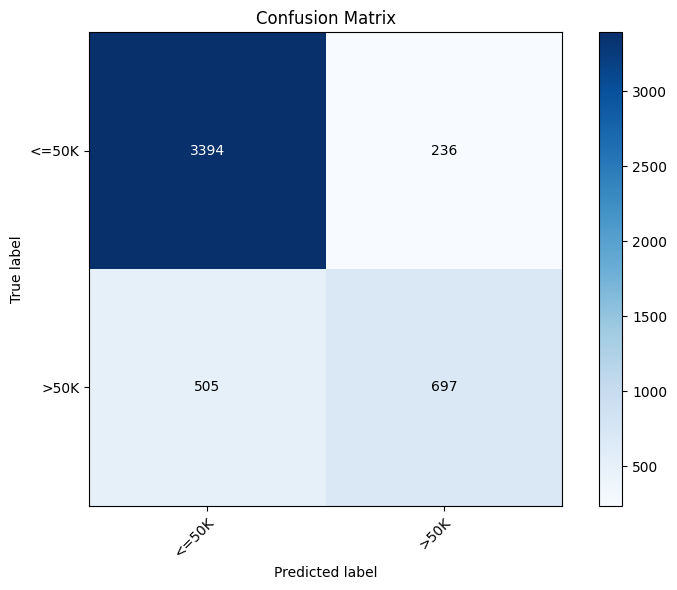

In [18]:
# Get the best estimator
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred_lr = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred_lr)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred_lr))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred_lr)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [19]:
# predict outputs for project_validation_inputs
# using the best model found above 

# X_validation already defined 

logreg_predictions = pd.DataFrame(best_model.predict(X_validation))

print(logreg_predictions.value_counts())


0    
<=50K    4816
>50K     1189
Name: count, dtype: int64


In [20]:
# Look at the predictions 
logreg_predictions

# Export to CSV
logreg_predictions.to_csv('Group_22_LogisticRegression_PredictedOutputs.csv', index=False)

In [21]:
def plot_logistic_regression_decision_boundary(grid_search, X, y, feature_x, feature_y):
    """
    Plot the decision boundary for the best Logistic Regression model
    on a specific pair of features.

    Args:
        grid_search (GridSearchCV): fitted GridSearchCV object.
        X (pd.DataFrame): feature matrix (with column names).
        y (pd.Series or np.ndarray): target labels.
        feature_x (str): name of the first feature to plot.
        feature_y (str): name of the second feature to plot.
    """
    best_params = grid_search.best_params_

    # Encode y if needed
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    y_series = pd.Series(y).ravel()
    if y_series.dtype == "object":
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series

    # Select two features
    X_pair = X[[feature_x, feature_y]]

    # Retrain best model on just these features
    plot_model = LogisticRegression(
        C=best_params.get("C"),
        solver=best_params.get("solver", "lbfgs"),
        max_iter=best_params.get("max_iter", 1000)
    )
    plot_model.fit(X_pair.values, y_encoded)

    # Scatter plot
    plt.figure(figsize=(7, 6))
    plt.scatter(X_pair[feature_x], X_pair[feature_y],
                c=y_encoded, cmap=plt.cm.coolwarm, s=30, edgecolors="k")

    # Decision boundary
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300),
                         np.linspace(ylim[0], ylim[1], 300))
    Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Labels
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"Logistic Regression Decision Boundary\n({feature_x} vs {feature_y})\nBest Params: {best_params}")
    plt.show()

/tmp/ipykernel_730/2591398787.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_series = pd.Series(y).ravel()


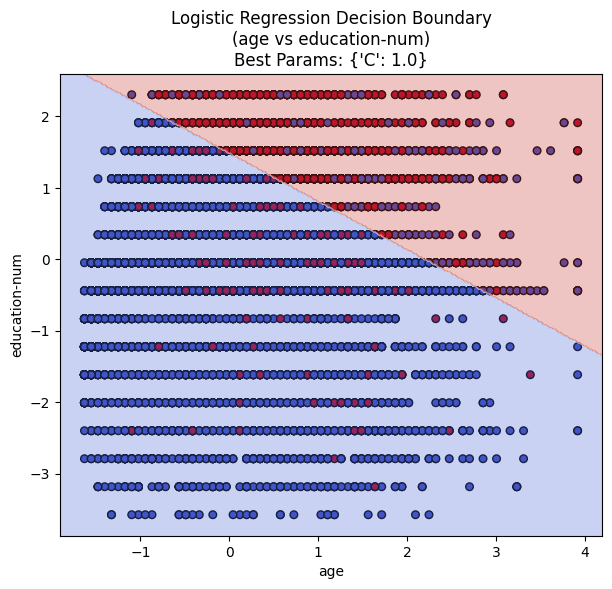

In [22]:
# Plot decision boundary for two selected features: age and occupation
plot_logistic_regression_decision_boundary(grid_search, X_train, y_train, "age", "education-num")

#### SVM

In [23]:
def plot_svm_decision_boundaries_multi_feature(X, y, kernels, title_prefix="", C=1.0, gamma='scale'):
    """
    Plots the decision boundaries for multiple SVM models and multiple feature pairs,
    automatically handling non-numerical target labels and different data types for y.

    Args:
        X (pd.DataFrame): The input features (must have at least 2 columns).
        y (pd.Series or np.ndarray or pd.DataFrame): The target labels.
        kernels (list): A list of kernel strings (e.g., 'linear', 'rbf', 'poly').
        title_prefix (str): A prefix for the plot titles.
        C (float): The regularization parameter.
        gamma (str or float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    """
    # Standardize the y input to a pandas Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        # Convert to Series for consistent handling, and ravel to ensure 1D
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")

    # Check the dtype of the uniform y_series and encode if necessary
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    n_kernels = len(kernels)

    fig, axes = plt.subplots(n_kernels, n_pairs, figsize=(n_pairs * 6, n_kernels * 5),
                             constrained_layout=True)

    # Ensure axes is a 2D array even for a single row/column
    if n_kernels == 1 and n_pairs == 1:
        axes = np.array([[axes]])
    elif n_kernels == 1:
        axes = np.array([axes])
    elif n_pairs == 1:
        axes = axes.reshape(-1, 1)

    for i, kernel in enumerate(kernels):
        for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
            ax = axes[i, j]

            # Select the two features for the current plot
            X_pair = X.iloc[:, [f1_idx, f2_idx]]
            f1_name = X.columns[f1_idx]
            f2_name = X.columns[f2_idx]

            # Train the SVM model on the selected features
            if kernel == 'poly':
                model = SVC(kernel=kernel, C=C, gamma=gamma, degree=3)
            else:
                model = SVC(kernel=kernel, C=C, gamma=gamma)
            
            # FIT THE MODEL WITH .values TO AVOID THE WARNING
            model.fit(X_pair.values, y_encoded)

            # Plot the data points with encoded labels
            ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

            # Create and plot the decision boundary
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                 np.linspace(ylim[0], ylim[1], 500))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
            
            # Highlight the support vectors
            ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='k')
            
            # Set titles and labels
            ax.set_title(f"{title_prefix} {kernel.capitalize()} ({f1_name} vs {f2_name})")
            ax.set_xlabel(f1_name)
            ax.set_ylabel(f2_name)
            ax.set_aspect('equal', adjustable='box')

    plt.show()

In [24]:
def plot_best_svm_decision_boundary(grid_search, X, y, feature_indices):
    """
    Plots the decision boundaries for the best SVM model found by GridSearchCV.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found
    print("DEBUG: Got best_ vars")

    # Standardize the y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]

    if feature_indices is None:
        # Default to the first two features if none are specified
        feature_pairs = [(0, 1)] 
    elif len(feature_indices) == 2 and all(0 <= i < n_features for i in feature_indices):
        feature_pairs = [feature_indices]
    else:
        raise ValueError("feature_indices must be a tuple of exactly two valid feature indices.")

    print(f"DEBUG: n_features = {n_features}")
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    # feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    
    fig, axes = plt.subplots(1, n_pairs, figsize=(n_pairs * 6, 6), constrained_layout=True)

    # Ensure axes is an array even for a single subplot
    if n_pairs == 1:
        axes = [axes]

    for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
        ax = axes[j]
        print(f"DEBUG: ax = {ax}")
        
        # Select the two features for the current plot
        X_pair = X.iloc[:, [f1_idx, f2_idx]]
        f1_name = X.columns[f1_idx]
        f2_name = X.columns[f2_idx]
        print(f"DEBUG: f1_name: {f1_name}")
        print(f"DEBUG: f2_name: {f2_name}")

        # Use the best model from GridSearchCV
        model = best_model
        
        # Since the best model was trained on the full dataset, we'll retrain
        # a new instance of it on just the two features for plotting purposes.
        # This is the most reliable way to ensure the decision boundary is correct.
        plot_model = SVC(
            kernel=best_params.get('kernel'),
            C=best_params.get('C'),
            gamma=best_params.get('gamma')
        )

        print("DEBUG: plot_model complete")

        if best_kernel == 'poly':
            plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
        plot_model.fit(X_pair.values, y_encoded)
        
        # Plot the data points
        ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        print("DEBUG: ax.scatter complete")

        # Create and plot the decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                             np.linspace(ylim[0], ylim[1], 500))
        Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        print("DEBUG: ax.contour complete")
        
        # Highlight the support vectors
        ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # Set titles and labels
        ax.set_title(f"Best Model ({best_kernel.capitalize()} kernel)\n({f1_name} vs {f2_name})")
        ax.set_xlabel(f1_name)
        ax.set_ylabel(f2_name)
        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(f"GridSearchCV Best Model Decision Boundaries\nBest Params: {best_params}", y=1.05)
    plt.show()

In [25]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# 1. SAMPLE THE DATA (25% for faster search)
# This is the only way I could get it to actually finish running
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=0.25, stratify=y_train, random_state=42
)

# Define the parameter grid to search over.
param_grid = {
    'C': [0.01, 1.0, 100.0],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_sample, y_sample.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,SVC()
,param_grid,"{'C': [0.01, 1.0, ...], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.01



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.7512

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.7512

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.75      1.00      0.86      3630
        >50K       0.00      0.00      0.00      1202

    accuracy                           0.75      4832
   macro avg       0.38      0.50      0.43      4832
weighted avg       0.56      0.75      0.64      4832


Confusion Matrix:
[[3630    0]
 [1202    0]]


/home/brynn/Repos/ML/pyml-book2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/brynn/Repos/ML/pyml-book2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/brynn/Repos/ML/pyml-book2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

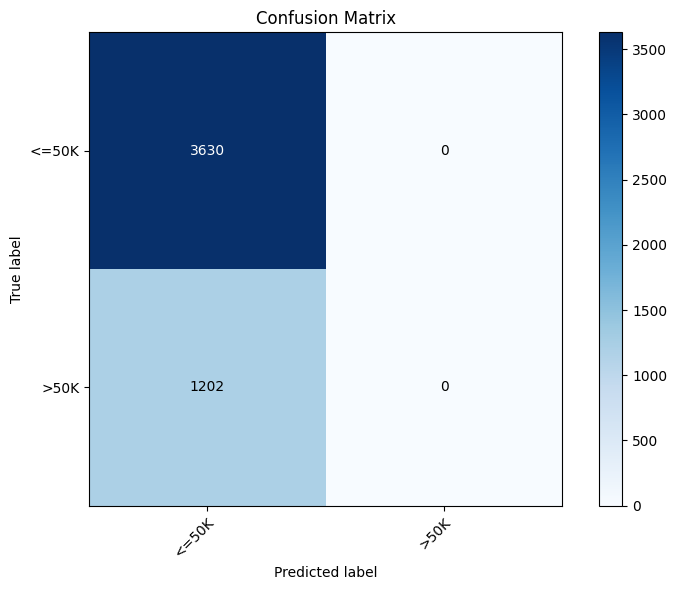

In [26]:
# Get the best estimator from the search.
best_model_svm = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred_svm = best_model_svm.predict(X_test)
final_accuracy_svm = accuracy_score(y_test, final_y_pred_svm)

print(f"Final accuracy on test set: {final_accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred_svm))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred_svm)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

/tmp/ipykernel_730/1770039518.py:21: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_series = pd.Series(y).ravel()


DEBUG: Got best_ vars
Encoding string labels to numerical format...
DEBUG: n_features = 97
DEBUG: ax = Axes(0.125,0.11;0.775x0.77)
DEBUG: f1_name: age
DEBUG: f2_name: education-num
DEBUG: plot_model complete
DEBUG: ax.scatter complete
DEBUG: ax.contour complete


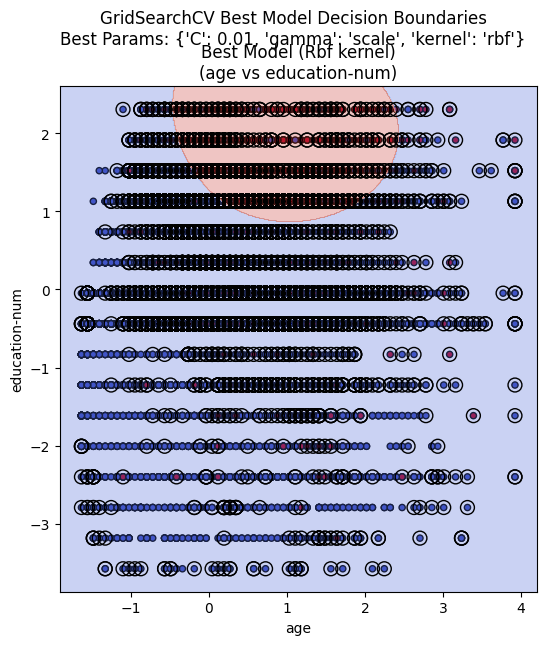

In [27]:
# Plot decision boundaries for age and education-num
plot_best_svm_decision_boundary(grid_search, X_train, y_train, feature_indices=(1,3))

In [29]:
# Repeat with linear 
# Define the parameter grid to search over.
param_grid2 = {
    'C': [0.01, 1.0, 100.0],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search2 = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid2,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search2.fit(X_sample, y_sample.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
# Get the best estimator from the search.
best_model_svm = grid_search2.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search2.best_params_}")
print(f"Best cross-validation accuracy: {grid_search2.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred_svm = best_model_svm.predict(X_test)
final_accuracy_svm = accuracy_score(y_test, final_y_pred_svm)

print(f"Final accuracy on test set: {final_accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred_svm))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred_svm)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [ ]:
# Plot decision boundaries for age and education-num
plot_best_svm_decision_boundary(grid_search, X_train, y_train, feature_indices=(1,3))

In [ ]:
# predict the validation set 

# X_validation already defined 

svm_predictions = pd.DataFrame(best_model_svm.predict(X_validation))

print(svm_predictions.value_counts())


0    
<=50K    5204
>50K      801
Name: count, dtype: int64


In [ ]:
# Look at the predictions
svm_predictions

# Export to CSV
svm_predictions.to_csv('Group_22_SVM_PredictedOutputs.csv', index=False)

## Question 4

#### Why is feature scaling important for gradient-based algorithms? 

Feature scaling is a crucial step in data preprocessing for gradient-based algorithms because it facilitates an unbiased comparison between features. Consider an instance where one feature has values ranging from 0-1,000,000 while another feature ranges from 0-1. The drastic difference between the scales of these features will result in more weight being given to the feature with a larger range of values. This will result in a biased model and inaccurate results. Transforming the data to have a similar scale will prevent these inaccuracies. Feature scaling can also help algorithms converge quicker. 

#### Explain the difference between batch gradient descent and stochastic gradient descent.

Batch gradient descent (BGD) uses the entire dataset in every iteration to calculate the gradient of the loss function, while stochastic gradient descent (SGD) only uses a small subset of the data in each iteration. This can make SGD converge quicker and reduce overfitting, but the use of a subset of data means that the estimates can be less accurate than BGD. It is also important to note that SGD may converge to a local minimum rather than a global minimum, whereas BGD converges to the global minimum more reliably. 

#### Why do scikit-learn's Perceptron and Adaline algorithms outperform book code? 

Scikit-learn's algorithms outperform the book code because scikit-learn automatically adds things like L2 regularization and optimization to the algorithm, which helps prevent overfitting and high variance. This can also make scikit-learn's algorithms more efficient than the book code. An example of the automatic regularization/optimization could include the use of cross validation in the gridsearch algorithm. This allows gridsearch to outperform manual hyperparameter tuning. 

#### Compare the decision boundaries of logistic regression and SVM.



#### What is the role of regularization in preventing overfitting?

Regularization utilizes a penalty in the loss function that penalizes certain values, usually extreme values. Doing this prevents the model from fitting the data too closely, and helps maintain a lower variance. The strength of the regularization can be controlled by tuning lambda, where a higher value of lambda results in stronger regularization/simpler model. The two main techniques are L1 and L2 regularization, with the main difference being the coefficients. L1 regularization keeps some coefficients at 0, while the coefficients of L2 regularization are small but never 0. While both methods simplify the model and prevent overfitting, L2 regularization strikes a balance between bias and variance. 

#### Vary the C values of the scikit-learn LogisticRegression and linear SVC models with [0.01, 1.0, 100.0]. Discuss the impact. 

LogisticRegression: GridSearchCV selected 1 as the best C value, resulting in an accuracy of 0.8079 on the test set. Setting C = 0.01 resulted in an accuracy of 0.8075, and setting C = 100.0 resulted in an accuracy of 0.8065. We can see that changing the value of C resulted in very small accuracy changes for LogisticRegression, and as the value of C increased, fewer records were accurately predicted as <=50K. 

Linear SVC: GridSearchCV selected 0.01 as the best C value, resulting in an accuracy of 0.8007 on the test set. Changing C to 1.0 resulted in an accuracy of 0.7926, and changing C to 100.0 produced an accuracy of 0.7935. Changing the value of C resulted in small fluctuations in the accuracy of the predictions, and as the value of C increased, fewer records were acurately predicted as >50K. 

C is a regularization parameter that helps find the balance between overfitting and underfitting. A higher value for C means that it will fit the data more closely and have a more complex decision boundary, but this will result in overfitting and the model will not be generalizable. On the other hand, a lower value for C means that the data will have a smoother decision boundary and will not fit the data as closely, which can result in a low accuracy. It is important to find the right C value so that the model can be both generalizable and accurate. GridSearchCV selected 1 as the best C value for LogisticRegression, while 0.01 was chosen for the SVM model. This makes sense because a higher C value could result in overfitting, leading to a lower accuracy score on unseen data. 